# Project: Investigate a Dataset (Investigating Gapminder Data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

Over time, countries develop in terms of productivity often measured in GDP. As GDP rises, there is often an acompanying change in workforce composition and median age. This investigation aims to investigate metrics from four datasets from the gapminder website in order to analyze what the general trends are.

In order to help group the dataset by continents/regions and sub-regions, a CSV file containing this information was also downloaded. 

The directing questions for this investigation is as follows:

<ol>
<li>As a country develops, how does the composition of its workforce change?</li>
<li>Which countries are progressing the fastest?</li>
<li>What can countries expect as their GDP rises?</li>
<li>How does the age of a country change over time?</li>
</ol>

<b>Datasets analyzed:</b>

<ul>
<li>Gross Domestic Product per capita in constant USD (value from the year 2000)</li>
    <ul>
    <li>Adjusted</li>
    <li>Not adjusted for differences in cost of living between countries</li>
    </ul>
<li>Agriculture workers (% total labor force)</li>
<li>Industry workers (% total labor force)</li>
<li>Service workers (% total labor force)</li>
</ul>

<b>The parameters used will be as follows:</b>

<ul>
<li>Independent variable:</li>
    <ul>
    <li>Time</li>
    </ul>
<li>Dependent variables:</li>
    <ul>
    <li>GDP</li>
    <li>% employment in Agriculture, Service and Industrial sectors</li>
    <ul>
</ul>


In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

### Defining Functions

In [2]:
def df_T_properly(df):
    """
    Transposes the dataframe, sets the column titles to the first row in the 
    transposed dataframe before removing the first row and returning the pro-
    perly transposed.
    
    Used in: calculate_nan_density_country(df_list)
    """
    
    # Transpose dataframe 
    df2 = df.transpose()
    
    # Rename columns
    df2.columns = df2.iloc[0]
    
    # Reset columns
    df3 = df2.reindex(df2.index.drop('Country'))
    
    return df3

In [3]:
def plot_nan_density_year(df, df_name, x_label = "Year"):
    """
    Calculates the density of non-NaN values inside of a dataframe for each 
    row (i.e. year) and creates a plot with specified title showing this change.
    """
    
    # Calculate density per row
    year = []
    density = []
    for i in range(df.shape[1]):
        if i == 0: continue
        year.append(int(df.columns[i]))
        density.append(df.iloc[:, i].count()/len(df.iloc[:, i]))
    
    # Plot Results
    plt.plot(year, density)
    plt.xlabel(x_label)
    plt.ylabel("Non-NaN Density")
    plt.title("Non-NaN values for {}".format(df_name))
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.show()

In [4]:
def basic_plot(x_series, y_series, x_label = "x", y_label="y", 
               y_ticks=False, plt_title = "plot"):
    """
    Creates a basic plot from two series, used for creating quick and dirty
    plots.
    
    For changing the xticks, input an integer for reduced_xticks. This only
    works if x_series can be converted to an integer
    
    You can also adjust the yticks by adding a tuple in the form of 
    (start, finish)
    """
    
    # Change years to int
    x_series = x_series.astype(int)
     
    # Create plot
    plt.plot(x_series, y_series, c='red')
    plt.xlabel(x_label)
    if y_ticks: plt.yticks(y_ticks)
    plt.ylabel(y_label)
    plt.title(plt_title)
    plt.show

In [5]:
def calculate_nan_density_country(df_list):
    """
    Looks at a list of dataframes and calculates the NaN density for each 
    country and returns that information inside of a datafame.
    
    Section of code will try to find the largest intersection of countries
    shared by all dataframes.
    
    This is so that the data can be grouped-by filtered and merged with other dfs
    later which will help gain into more insight into which columns that need to
    be dropped or transformed in some way.
    
    Dependencies: 
        country_check(check_country, df)
        common_countries(smallest_list)
        df_T_properly(df)
    """
    
    # Initialize values
    n_countries = {}
    smallest = 1e400
    
    # Find dataframes with lowest number of nonNaN rows
    for df in df_list:
        
        # Create relevant entry in dictionary
        if not eval(df).shape[0] in n_countries.keys(): n_countries[eval(df).shape[0]]=[df]
        else: n_countries[eval(df).shape[0]].append(df)
            
        # Keep track of smallest value
        if eval(df).shape[0] < smallest: 
            smallest = eval(df).shape[0]
    
    # Check smallest number of countries is unique
    if len(n_countries[smallest]) > 1:
        
        # Rename list
        smallest_list = n_countries[smallest]
        
        # Find unique columns
        check_country = common_countries(smallest_list)
    
    else: check_country =  list(eval(n_countries[smallest][0])['Country'])
    
    # Check that all check_country appear in ccode
    check_country2 = country_check(check_country, df_ccode)
    check_country3 = country_check(check_country2, df_GDP)
    check_country4 = country_check(check_country3, df_age)
    
    # Create dictionary which will be converted to dataframe
    dict_to_df = {}
    
    # Fill dictionary with relevant values
    for country in check_country4:

        # Init. row list
        row_list = [] 
        
        for df in df_list:
            # Calculate length
            
            df_row_length = eval(df)[eval(df)['Country']==country].iloc[0, 1:].notnull().count()
            
            # Calculate non-NaN values
            df_row_nonNaN = eval(df)[eval(df)['Country']==country].iloc[0, 1:].notnull().sum()
            
            # Append to List
            row_list.append(df_row_nonNaN/df_row_length)
        
        # Insert values into dictionary
        dict_to_df[country] = row_list
        
    # Convert dictionary to dataframe and transpose
    return_df = pd.DataFrame(dict_to_df)
    return_df.insert(loc = 0, column = 'Country', value = df_list)
    return_df = df_T_properly(return_df)
    
    return return_df

In [6]:
def common_countries(smallest_list):
    """
    Checks a list of strings that can be evaluated to dataframes and returns 
    countries which are not found in all dataframes.
    
    Used in: calculate_nan_density_country(df_list)
    """

    # Init. list
    ignore_country = []
    check_country= []

    # Check columns
    for i in range(len(smallest_list)):
        
        # Init j value to compare with later dfs
        j = i
        
        # Check larger dfs
        while j < len(smallest_list):
            
            # Find unique columns
            set_diff = set(eval(smallest_list[i])['Country']).difference(
                       set(eval(smallest_list[j])['Country']))
            
            # Add new unique columns to list
            for k in set_diff:
                if k not in ignore_country: ignore_country.append(k)
            
            # Increment j for next loop
            j+=1
        
    # find check_columns
    for df in smallest_list:
        good_columns = list(set(eval(df).Country).difference(set(ignore_country)))
        for col in good_columns:
            if col not in check_country: check_country.append(col)
    
    return check_country

In [7]:

def country_check(check_country, df):
    """
    Makes sure that each country can be found in df.
    
    Used in: calculate_nan_density_country(df_list)
    """
    
    # Init. list
    check_country2 = []
    
    # Check columns
    for country in check_country:
        try: 
            if country in list(df['name']): check_country2.append(country)
        except KeyError: 
            if country in list(df['Country']): check_country2.append(country)
    
    return check_country2

In [8]:
def imputation_average(df):
    """
    Takes dataframe and imputes missing values for each column by using the
    mean of the column. Dataframe is then returned with all column names and
    indexesintact.
    """
    
    # Iterate over columns
    for i in range(df.shape[0]):
        
        # Calculate column mean
        row_mean = df.iloc[i, 1:].mean()
        
        # Fill NaN values
        df.iloc[i]=df.iloc[i].fillna(row_mean)
        
    return df

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [9]:
# Import data
df_GDP = pd.read_csv('data_csv/GDPpercapitaconstant2000US.csv')
df_agric = pd.read_csv('data_csv/indicator_t agriculture employ.csv')
df_indus = pd.read_csv('data_csv/indicator_t industry employ.csv')
df_servi = pd.read_csv('data_csv/indicator_t service employ.csv')
df_age = pd.read_csv('data_csv/indicator_median age.csv')
df_ccode = pd.read_csv('data_csv/country_codes.csv')

In [10]:
df_GDP.head()

,Country,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,Abkhazia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Akrotiri and Dhekelia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1313.722725,1381.040832,1454.022854,1525.723589,1594.495067,1681.613910,1804.419415,1857.352947,1915.424459,1965.707230
4,Algeria,1280.384828,1085.414612,855.947986,1128.41578,1170.323896,1215.015783,1127.614288,1200.558225,1291.863983,...,1871.921986,1971.512803,2043.135713,2115.186028,2124.957754,2155.485231,2173.787903,2192.703976,2231.980246,2255.225482


In [11]:
df_agric.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,21.1,NaN,21.1,20.700001,NaN,NaN,NaN
1,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.3,NaN,2.9,NaN,NaN,NaN,NaN,NaN,NaN
4,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.6,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_indus.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,24.299999,NaN,24.0,26.0,NaN,NaN,NaN
1,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,20.5,NaN,18.900000,NaN,NaN,NaN,NaN,NaN,NaN
4,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,14.600000,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_servi.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,54.500000,NaN,54.799999,53.0,NaN,NaN,NaN
1,American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67.5,NaN,76.699997,NaN,NaN,NaN,NaN,NaN,NaN
4,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,74.599998,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_age.head()

,Median age,1950,1955,1960,1965,1970,1975,1980,1985,1990,...,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
0,Afghanistan,18.597,18.462,18.311,18.193,17.994,17.648,17.357,17.091,16.845,...,16.490,16.868,17.326,17.810,18.319,18.936,19.775,20.918,22.196,23.522
1,AFRICA,19.173,18.862,18.434,18.020,17.690,17.524,17.505,17.443,17.541,...,19.058,19.676,20.401,21.233,22.245,23.381,24.593,25.851,27.153,28.492
2,Albania,20.640,20.202,19.677,18.955,18.844,19.490,21.349,22.505,23.815,...,28.532,29.968,31.796,33.636,35.737,37.988,40.292,42.258,43.702,44.268
3,Algeria,19.927,19.307,18.170,16.742,15.808,16.165,16.910,17.318,18.183,...,24.015,26.247,28.311,30.333,32.300,34.187,35.547,36.877,38.145,39.416
4,Angola,19.401,18.882,18.244,17.481,16.987,16.828,16.652,16.449,16.198,...,16.718,17.385,17.989,18.658,19.510,20.435,21.623,22.891,24.197,25.561


In [15]:
df_ccode.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,region-code,sub-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0



From the above "heads" of the dataframes, it is possible to see that a LOT of data is missing from these CSV files. This is likely because data tracking has only become easy within the last couple of decades, this is especially true for countries that are still developing.

Hence, this creates an immediate bias in any analysis that will be done in this notebook where the information about more economically developed countries (MEDCs) will be more accurate and complete than less economically developed countries (LEDCs).

If there are only a couple of missing values then it is usually possible to impute an average and fill these spaces. However, there are many data series where more than 50% of the data is missing. I will find the rows (countries) which have more than 70% filled data and keep those rows. The rest of the rows will be dropped because they do not contain enough information to be of use. (At least, not in a way that produces anything non-artificial or low resolution.)

### Data Cleaning (Finding countries with "more complete" data¶)

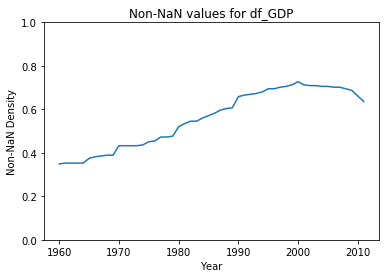

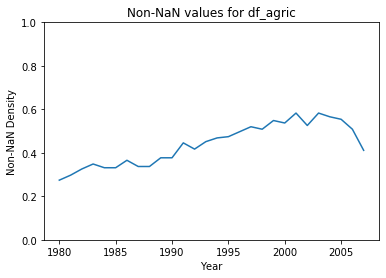

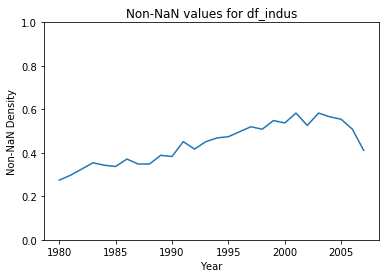

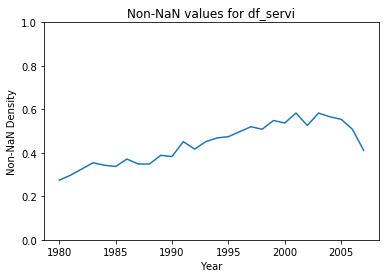

In [16]:
# Drop columns from df_ccode which will not be used
df_ccode.drop(['alpha-2','alpha-3' ,'country-code', 'iso_3166-2', 'region-code',
               'sub-region-code'], axis=1, inplace=True)

# Rename bad label in df_age
df_age.rename(columns={'Median age': 'Country'}, inplace=True)

# Create dataframe list
df_list = ["df_GDP", "df_agric", "df_indus", "df_servi", "df_age"]

for df in df_list:
    if df == 'df_age': continue # Skip df_age, no NaN values
    plot_nan_density_year(eval(df), df)

In these plots we can see how NaN density drops over time and suddenly spikes after the turn of the millenia, I am not exactly sure as to why this is but it's worth noting.

In [17]:
# Calculate Non-NaN density for each country
meta_df_NaN_Density = calculate_nan_density_country(df_list)

# Fix indexing issues
meta_df_NaN_Density.reset_index(inplace=True)
meta_df_NaN_Density.rename(columns={'index': 'Country'}, inplace=True)

meta_df_NaN_Density.head()

Country,Country,df_GDP,df_agric,df_indus,df_servi,df_age
0,Madagascar,1,0.0714286,0.0714286,0.0714286,1
1,Ireland,0.807692,0.857143,0.857143,0.857143,1
2,Nepal,1,0.107143,0.107143,0.107143,1
3,Canada,1,1,1,1,1
4,Cambodia,0.365385,0.142857,0.142857,0.142857,1


In [18]:
# Find countries with Non-NaN densities higher than 0.7
threshold = 0.70
mdND_70 = meta_df_NaN_Density[(meta_df_NaN_Density['df_GDP'] > threshold) &\
                              (meta_df_NaN_Density['df_agric'] > threshold) &\
                              (meta_df_NaN_Density['df_indus'] > threshold) &\
                              (meta_df_NaN_Density['df_servi'] > threshold) &\
                              (meta_df_NaN_Density['df_age'] > threshold)]

# Join with df_ccode to determine general locations of countries
df_ccode.rename(columns={'name': 'Country'}, inplace=True)
mdND_70 = df_ccode.merge(right = mdND_70, how='inner', on='Country')

# Define countries to investigate
country_list = list(mdND_70['Country'])

mdND_70.head()


,Country,region,sub-region,df_GDP,df_agric,df_indus,df_servi,df_age
0,Argentina,Americas,South America,1,0.714286,0.714286,0.714286,1
1,Australia,Oceania,Australia and New Zealand,1,1,1,1,1
2,Austria,Europe,Western Europe,1,0.892857,0.892857,0.892857,1
3,Barbados,Americas,Caribbean,0.961538,0.857143,0.857143,0.857143,1
4,Belgium,Europe,Western Europe,1,0.785714,0.785714,0.785714,1



Now that we know which countries have complete data, we can aggregate this data so that we know what regions or sub-regions these countries come from.

In [19]:
# Count rows by region
mdND_70.groupby('region')['Country'].count()

region
Africa       1
Americas    10
Asia        10
Europe      15
Oceania      1
Name: Country, dtype: int64

In [20]:
# Count rows by sub-region
mdND_70.groupby('sub-region')['Country'].count()

sub-region
Australia and New Zealand    1
Caribbean                    3
Central America              3
Eastern Asia                 1
Eastern Europe               1
Northern Africa              1
Northern America             1
Northern Europe              5
South America                3
South-Eastern Asia           5
Southern Asia                1
Southern Europe              4
Western Asia                 3
Western Europe               5
Name: Country, dtype: int64

As we can see, most of the data comes from The Americas, Europe and Asia. Data from Africa is relatively incomplete which makes it harder to do analysis on it without completely fabricating the data. This is a bias that will just need to be accepted for this analysis, to improve in this bias more complete data over Africa will need to be recorded in the future which will become easier as the contitnent's infrastructures develop.

### Update Dataframes

In [21]:
# Update dataframes in df_T_List to contain the relevant countries
df_GDP = df_GDP[df_GDP['Country'].isin(country_list)]
df_agric = df_agric[df_agric['Country'].isin(country_list)]
df_indus = df_indus[df_indus['Country'].isin(country_list)]
df_servi = df_servi[df_servi['Country'].isin(country_list)]
df_age = df_age[df_age['Country'].isin(country_list)]

In [22]:
# Impute NaN values - Once again, no need to do anything with df_age
df_GDP = imputation_average(df_GDP)
df_agric = imputation_average(df_agric)
df_indus = imputation_average(df_indus)
df_servi = imputation_average(df_servi)

In [23]:
## check column values are appropriate
#df_GDP.info()
#df_agric.info()
#df_indus.info()
#df_servi.info()

In [24]:
# Change percentage range from 0-100 to 0-1
df_agric.iloc[:, 1:] = df_agric.iloc[:, 1:].divide(other=100)
df_indus.iloc[:, 1:] = df_indus.iloc[:, 1:].divide(other=100)
df_servi.iloc[:, 1:] = df_servi.iloc[:, 1:].divide(other=100)

In [25]:
# Merge region and sub-region into dataframes
df_GDP = df_ccode.merge(right = df_GDP, how='inner', on='Country')
df_agric = df_ccode.merge(right = df_agric, how='inner', on='Country')
df_indus = df_ccode.merge(right = df_indus, how='inner', on='Country')
df_servi= df_ccode.merge(right = df_servi, how='inner', on='Country')
df_age = df_ccode.merge(right = df_age, how='inner', on='Country')

In [26]:
df_GDP.head()

,Country,region,sub-region,1960,1961,1962,1963,1964,1965,1966,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
0,Argentina,Americas,South America,5251.876754,5448.303627,5316.578969,4956.216522,5375.463707,5855.611563,5733.311946,...,6428.393836,6933.155594,7492.249508,8107.975365,8717.176296,9388.688523,9935.834246,9933.229024,10749.319224,11601.630223
1,Australia,Oceania,Australia and New Zealand,9407.685082,9451.546304,9351.023272,9749.128563,10231.144465,10633.094400,10635.677912,...,22402.991019,22825.571022,23498.261991,23929.164397,24295.081380,24765.548902,25190.720626,25007.697756,25190.839860,25306.824938
2,Austria,Europe,Western Europe,7434.183717,7802.972546,7960.707270,8237.060529,8683.454516,8927.460698,9365.306134,...,24375.113835,24466.706298,24945.047766,25370.465866,26171.690912,27036.487332,27305.923295,26183.997598,26642.993858,27266.403350
3,Barbados,Americas,Caribbean,3396.945712,3646.654780,3961.399895,3744.022688,3915.325593,4347.904449,4509.680501,...,8717.534639,8873.568078,9181.616033,9454.342464,9757.443433,9783.984173,9781.356913,9243.587053,7297.016106,7297.016106
4,Belgium,Europe,Western Europe,7454.716536,7799.889081,8173.818456,8465.979625,8969.632551,9205.035593,9431.614088,...,23008.449937,23097.212617,23750.459812,24033.783302,24512.413136,25034.666923,25082.374127,24190.594952,24550.396553,24733.626956


In [27]:
df_agric.head()

,Country,region,sub-region,1980,1981,1982,1983,1984,1985,1986,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Argentina,Americas,South America,0.006750,0.00675,0.00100,0.003,0.003,0.00675,0.00675,...,0.008,0.007,0.007,0.008,0.010,0.014,0.012,0.011000,0.008000,0.006750
1,Australia,Oceania,Australia and New Zealand,0.065000,0.06500,0.06400,0.066,0.062,0.06200,0.06000,...,0.049,0.050,0.050,0.048,0.045,0.039,0.038,0.036000,0.035000,0.034000
2,Austria,Europe,Western Europe,0.070680,0.07068,0.07068,0.099,0.094,0.09000,0.08600,...,0.066,0.062,0.059,0.057,0.057,0.056,0.050,0.055000,0.055000,0.057000
3,Barbados,Americas,Caribbean,0.061167,0.09400,0.08600,0.080,0.091,0.08500,0.08200,...,0.044,0.043,0.037,0.042,0.040,0.046,0.033,0.061167,0.061167,0.061167
4,Belgium,Europe,Western Europe,0.031000,0.03100,0.03100,0.031,0.031,0.03100,0.03000,...,0.023,0.020,0.018,0.016,0.017,0.017,0.020,0.020000,0.020000,0.024409


In [28]:
df_indus.head()

,Country,region,sub-region,1980,1981,1982,1983,1984,1985,1986,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Argentina,Americas,South America,0.263100,0.26310,0.29300,0.292,0.309,0.2631,0.2631,...,0.248,0.236,0.227,0.219,0.202,0.217,0.230,0.235000,0.237000,0.263100
1,Australia,Oceania,Australia and New Zealand,0.310000,0.30500,0.29700,0.284,0.280,0.2710,0.2660,...,0.218,0.213,0.218,0.209,0.210,0.210,0.212,0.211000,0.212000,0.212000
2,Austria,Europe,Western Europe,0.330560,0.33056,0.33056,0.388,0.381,0.3810,0.3780,...,0.304,0.306,0.306,0.299,0.296,0.296,0.278,0.276000,0.282000,0.273000
3,Barbados,Americas,Caribbean,0.207542,0.21600,0.23600,0.234,0.228,0.2320,0.2220,...,0.209,0.214,0.204,0.196,0.187,0.176,0.173,0.207542,0.207542,0.207542
4,Belgium,Europe,Western Europe,0.343000,0.32800,0.31800,0.310,0.304,0.2980,0.2920,...,0.251,0.267,0.263,0.260,0.254,0.248,0.249,0.247000,0.247000,0.276455


In [29]:
df_servi.head()

,Country,region,sub-region,1980,1981,1982,1983,1984,1985,1986,...,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
0,Argentina,Americas,South America,0.708450,0.70845,0.59500,0.585,0.566,0.70845,0.70845,...,0.740,0.753,0.762,0.769,0.785,0.763,0.755,0.751000,0.752000,0.708450
1,Australia,Oceania,Australia and New Zealand,0.624000,0.62700,0.63700,0.648,0.655,0.66700,0.67400,...,0.733,0.737,0.733,0.742,0.745,0.750,0.748,0.750000,0.750000,0.751000
2,Austria,Europe,Western Europe,0.596280,0.59628,0.59628,0.512,0.522,0.52600,0.53200,...,0.629,0.631,0.634,0.643,0.645,0.647,0.670,0.667000,0.661000,0.668000
3,Barbados,Americas,Caribbean,0.660417,0.69100,0.67700,0.685,0.681,0.68300,0.69500,...,0.628,0.640,0.644,0.655,0.659,0.668,0.697,0.660417,0.660417,0.660417
4,Belgium,Europe,Western Europe,0.626000,0.64000,0.65100,0.659,0.665,0.67100,0.67800,...,0.679,0.708,0.714,0.719,0.726,0.732,0.728,0.726000,0.728000,0.685727


In [30]:
df_age.head()

,Country,region,sub-region,1950,1955,1960,1965,1970,1975,1980,...,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
0,Argentina,Americas,South America,25.657,26.471,27.070,27.398,27.593,27.663,27.377,...,29.120,30.439,31.615,32.837,34.147,35.551,36.931,38.163,39.271,40.386
1,Australia,Oceania,Australia and New Zealand,30.379,30.158,29.608,28.295,27.608,28.019,29.380,...,36.553,37.776,38.842,39.600,40.432,41.213,41.925,42.440,42.728,42.937
2,Austria,Europe,Western Europe,35.696,35.201,35.524,34.972,33.892,33.818,34.671,...,39.953,41.768,43.495,44.785,45.604,46.579,47.460,48.196,48.655,48.543
3,Barbados,Americas,Caribbean,24.558,24.271,22.320,20.646,21.213,23.694,24.494,...,35.530,37.771,39.992,41.715,43.497,45.284,46.885,48.059,48.657,48.614
4,Belgium,Europe,Western Europe,35.526,34.713,35.246,34.752,34.580,34.037,34.210,...,40.232,41.301,42.380,43.175,43.742,44.231,44.628,44.925,44.879,44.684


This marks the completion of the data wrangling section. Wiring about it now makes it look easy but this took me a couple days of solid work in order to do this, very good experience for the future.

<a id='eda'></a>
## Exploratory Data Analysis

Just as a refresher, here are the questions which I wanted to answer using this dataset:

<b>Directing questions:</b>

<ul>
<li>As a country develops, how does the composition of its workforce change?</li>
<li>Which regions have progressed fastest in terms of GDP?</li>
<li>How does median age change with GDP?</li>
</ul>
Hence,

<ul>
<li>What can these countries expect as their GDP rises?</li>
</ul>
You can also view these questions in terms of region/sub-region

### Research Question 1 - As a country develops, how does the composition of its workforce change?¶

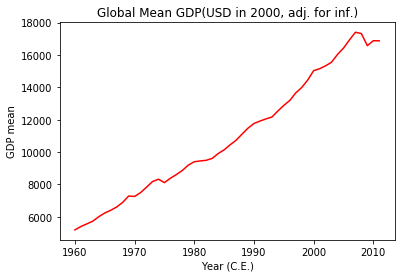

In [44]:
# Plot sample average GDP over time
basic_plot(x_series=np.array(df_GDP.mean().keys()), 
           y_series=df_GDP.mean().values, 
           x_label= "Year (C.E.)",
           y_label= 'GDP mean',
           plt_title='Global Mean GDP(USD in 2000, adj. for inf.)')

I just wanted to quickly show that it is true that countries tend to rise in GDP over time. That down-tick in 2008 is the credit-crunch ofcourse.

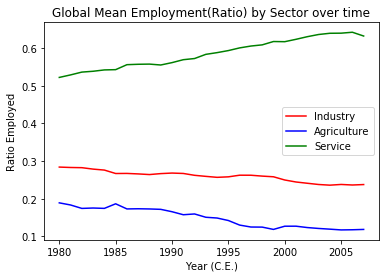

In [95]:
plt.plot(np.array(df_indus.columns[3:].astype(int)), df_indus.mean(), 
         c='red', label='Industry')
plt.plot(np.array(df_agric.columns[3:].astype(int)), df_agric.mean(), 
         c='blue', label='Agriculture')
plt.plot(np.array(df_servi.columns[3:].astype(int)), df_servi.mean(),
          c='green', label='Service')
plt.xlabel('Year (C.E.)')
plt.ylabel('Ratio Employed')
plt.title('Global Mean Employment(Ratio) by Sector over time')
plt.legend()
plt.show()

As we can see above, as a country develops there is a tendency for employment in service to increase and for employment in industry/agriculture to decrease. The time series of this data is too short to show what happened during the industrial revolution but if we were to look back that far we would likely find that most people were employed in agriculture and as technology made it possible to do greater work on the fields without as many workers, this changed as workers went into industry. Now, with the information revolution, we see an increasing amount of people going into the service industry as industrial jobs become automated.

This trend, where automation heavily effects what people do for a living is going to continue into the future. As to what that will mean for us we can't really see from this data because one would need more recent data where AI is playing a grater role in our soceity, during 2005 only the precurors of what comes in the next decade can be seen.

In [96]:
# Calculating correlation coefficients
corr_coeff_GDP_servi = np.corrcoef(x=df_GDP.mean()[20:-4], y=df_servi.mean())
corr_coeff_agric_indus = np.corrcoef(x=df_agric.mean(), y=df_indus.mean())

# Calculate correlation coefficient between GDP and service employment %
corr_coeff_GDP_servi

array([[1.        , 0.98120669],
       [0.98120669, 1.        ]])

In [97]:
# Calculating correlation coefficients
corr_coeff_agric_indus

array([[1.        , 0.85837619],
       [0.85837619, 1.        ]])

We can see here how GDP and service employment and a 98.3% correlation with each other, the employment in agriculture and industry are also strongly correlated.

However, is this correlation causal? We can use a t-test to figure out whether this is the case.

In [98]:
# Perform t-test on Service Employment ratio and GDP
serv_ratio_series = df_GDP.mean()[20:-4]
GDP_series = df_servi.mean()
t_test_serv_GDP = ttest_ind(serv_ratio_series, GDP_series) # Imported from Sci-Py Stats

t_test_serv_GDP

Ttest_indResult(statistic=27.152068970662953, pvalue=3.705968239571178e-33)

The p-value of the t-test is almost 0 which shows that the strong correlation is unlikely to be a coincidence and that there is a sort of causal link here. Whether or not GDP causes a higher %employment in service industries or vice. versa. is not known but at least it's worth knowing that these two features are correlated in this way.

### Research Question 2:  Which regions have progressed fastest in terms of GDP?¶


Text(0, 0.5, 'GDP')

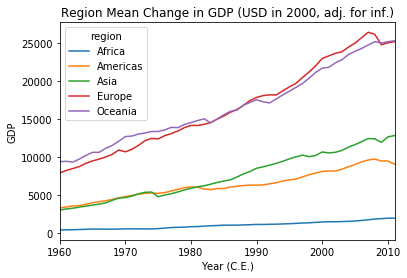

In [99]:
# Grouping GDP by region
ax = df_GDP.groupby('region').mean().T.plot(title='Region Mean Change in GDP (USD in 2000, adj. for inf.)')
ax.set_xlabel('Year (C.E.)')
ax.set_ylabel('GDP')

We can see here how certain continents have had an increase in productivity over time. It should be noted that Oceania and Africa represent the top GDP in their region instead of their average due to there being only one country being used for this analysis in both datasets.

The americas also also skewed upward due to the presence of North America which has a much higher GDP than the rest of america as can be seen from the plots below where I broke things down by sub-region.

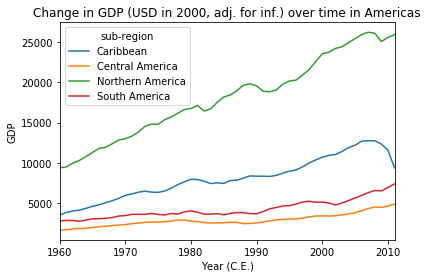

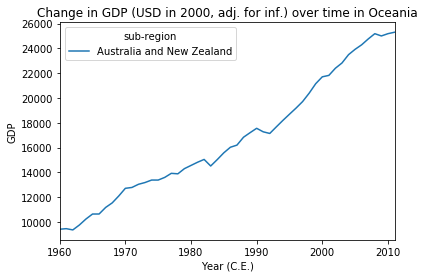

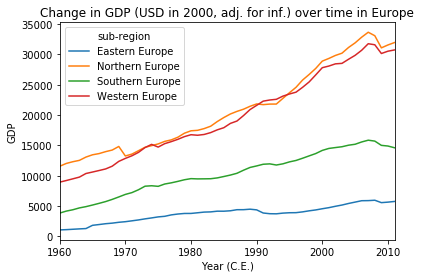

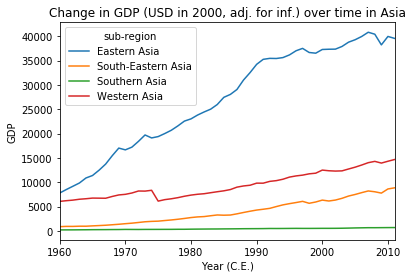

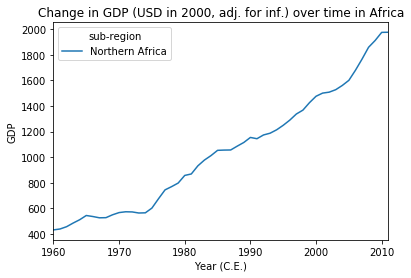

In [100]:
# How about Countries within a region?
for region in df_GDP['region'].unique():
    ax = df_GDP[df_GDP['region'] == region].groupby(
            'sub-region').mean().T.plot(title='Change in GDP (USD in 2000, adj. for inf.) over time in {}'.format(region))
    ax.set_xlabel('Year (C.E.)')
    ax.set_ylabel('GDP')

How you display your data makes a large difference in how you interpret it. In the previous graph, it looked as if Africa had barely made any improvement on its productivity. However this is only because of it being compared to countries that have had an increased rate of productivity for quite some time now.

When viewed on its own, Northern Africa had five-fold increase in productivity which is very promising. Furthermore, as the infrastructure develops, this rate of productivity increase will likely increase. It should still be noted that this is still one region of one of the largest continents on the planet and that regions with less economic development are missing from the data and so there is a bias which makes the situation look a little better than it is.

Interestingly, it is also possible to see how all have come level of inequality, where one sub-region has a higher GDP than the rest of the region. Perhaps this is due things like capital cities where most of the productivity that counts toward GDP is carried out?

### Research Question 3:  How does median age change with GDP?¶¶

So we have discovered that GDP and employment in the service industry are tightly linked and they are both proportional with time.

The decline in the agricultural and industrial industries are likely correlated with the growth of technology since the industrial revolution.

I also wanted to make a couple of quick graphs showing median age for my selection of countries. To do this I will create a violin plot which shows the median age for every half decade.

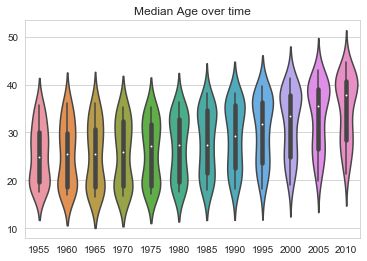

In [101]:
# Seaborn set style    
sns.set_style('whitegrid')

# Plot before and after world age distribution
ax = sns.violinplot(data=df_age.iloc[:, 4:-8]).set_title('Median Age over time')

Here we can see that in 1995 the median age was roughly 25 across the globe, but with a split between the "rich" and "poor" countries. Over 60 years of this graph we can see how the median age is pulled upward signifying a much longer lifespan than before.

The before/after effects can be seen most starkly when thee instances are seen side by side. For the sake of vareity, I'll use a boxplot instead of a violin plot.

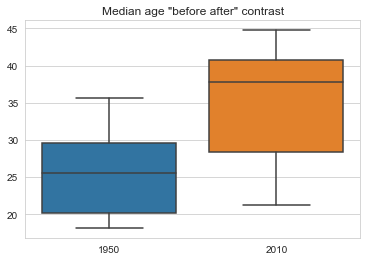

In [102]:
# Create boxplot
sns.boxplot(data=df_age[['1950', '2010']]).set_title('Median age "before after" contrast');

The world median has increased from roughly 25 years of age to 37 years of age. The median lifespan is so much higher that the top of the interquartile range (30) is now easily exceeded by 75% of the data in 2010.

<a id='conclusions'></a>
## Conclusions
<ol>
<li>It was found that countries on average tend to rise in GDP. Although it is suspected that this is due to technological development, from this data alone it is not possible to say why. (This trend can also be seen when making discreete plots.)</li>
    <ol>
    <li>However, as GDP rises, so does the percentage of people employed in the service sector, away from service and agriculture which have a correlation coefficient of 0.87.</li>
    <li>This shows that as people leave the agriculture and industrial sectors, they'll tend to enter into the service sector.</li>
    </ol>
<li>The correlation between the service sector and GDP is 0.98, which is very strong.</li>
    <ol>
    <li>The probability that this is due to random chance is roughly 5e-33 (very low) which suggests that there is some sort of a causal link although directionality was not determined in this study.</li>
    </ol>
<li>People are living much longer lives with the median age having risen substantially in the 60 years that the data shows.</li>
</ol>

It is important to keep in mind that this analysis has limitations due to GDP not being adjusted for differences in costs of living between countries. Missing data also means that this analysis is better suited for countries that are not experiencing extreme povery (which is most countries these days), many countries were dropped for having low data quality. This data is also over the course of roughly 20 years, which is too short a time scale to see how technology has impacted soceity over the course of time since the start of the industrial revolution which is where increased productivity and standards of living all started.

Naturally, the million-dollar question is "how will AI and qutomation" effect job sectors in the years to come? This question is difficult to answer because we're not sure what effects AI will have on our economy but answering it means a strategic advantage for whoever can make the right analysis.